In [1]:
import os
import math
import random
import warnings
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

# import tensorflow as tf
import numpy as np
import pandas as pd
# from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image

from scipy.ndimage import rotate
# import torch
# import torchvision.transforms as transforms
# from torchvision.transforms.functional import rotate, hflip, vflip

from tqdm import tqdm

2024-05-06 12:56:39.610548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 12:56:39.610665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 12:56:39.735536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Skin_df

In [2]:
skin_df = pd.read_pickle(os.path.join('/kaggle/input/final-augumented-data', 'skin_df.pkl'))

print('skin_df length -', len(skin_df))

skin_df length - 10015


In [ ]:
skin_df.sample(10)

In [3]:
# lesion_type_dict = {
#     'nv': 'Melanocytic nevi',
#     'mel': 'Melanoma',
#     'bkl': 'Benign keratosis-like lesions ',
#     'bcc': 'Basal cell carcinoma',
#     'akiec': 'Actinic keratoses',
#     'vasc': 'Vascular lesions',
#     'df': 'Dermatofibroma'
# }

# cell_type_idx, cell_type mapping
cell_type_mapping = dict(zip(skin_df['cell_type'], skin_df['cell_type_idx']))

for cell_type, idx in cell_type_mapping.items():
    print(f"Index: {idx}, {cell_type}")
print()
    
# skin_df image shape
print('\n', skin_df['image'].map(lambda x: x.shape).value_counts(), '\n')

Index: 2, Benign keratosis-like lesions 
Index: 4, Melanocytic nevi
Index: 3, Dermatofibroma
Index: 5, Melanoma
Index: 6, Vascular lesions
Index: 1, Basal cell carcinoma
Index: 0, Actinic keratoses


 image
(450, 600, 3)    10015
Name: count, dtype: int64 



# Exploratory Data Analysis

In [ ]:
skin_df['cell_type'].value_counts().plot(kind='bar')

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')

In [ ]:
skin_df['dx_type'].value_counts().plot(kind='bar')

In [ ]:
skin_df['age'].hist(bins=40)

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar')

In [ ]:
sns.scatterplot(x='age', y='cell_type_idx', data=skin_df)

### Plotting

In [ ]:
def plot_df(df, random=False):
    rows = df.head(9)
    
    if(random):    
        random_rows = df.sample(n=9)
        rows = random_rows

    fig, axes = plt.subplots(3, 3, figsize=(5, 5))

    for i, row in tqdm(enumerate(rows.itertuples(), 0)):
        img = row.image
        ax = axes[i // 3, i % 3]
        ax.imshow(img, cmap='gray')
        ax.set_title(row.dx)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Augumentation
##### Data augumentation is done, progress is saved in pickle files. 

### Reading pickle files nv, mel, bkl, mel, akiec, df, vasc

In [ ]:
ind_bcc = pd.read_pickle(os.path.join('/kaggle/input/final-augumented-data', 'ind_bcc.pkl'))
ind_bkl = pd.read_pickle(os.path.join('/kaggle/input/final-augumented-data', 'ind_bkl.pkl'))
ind_mel = pd.read_pickle(os.path.join('/kaggle/input/final-augumented-data', 'ind_mel.pkl'))
ind_akiec = pd.read_pickle(os.path.join('/kaggle/input/final-augumented-data', 'ind_akiec.pkl'))
ind_df = pd.read_pickle(os.path.join('/kaggle/input/final-augumented-data', 'ind_df.pkl'))
ind_nv = pd.read_pickle(os.path.join('/kaggle/input/final-augumented-data', 'ind_nv.pkl'))
ind_vasc = pd.read_pickle(os.path.join('/kaggle/input/final-augumented-data', 'ind_vasc.pkl'))

In [ ]:
print('Size after augumentation: ')
print('nv -', len(ind_nv))
print('mel -', len(ind_mel))
print('bkl -', len(ind_bkl))
print('bcc -', len(ind_bcc))
print('akiec -', len(ind_akiec))
print('vasc -', len(ind_vasc))
print('df -', len(ind_df))

In [ ]:
ind_nv.sample(5)

In [ ]:
ind_bcc.sample(5)

In [ ]:
ind_bkl.sample(5)

In [ ]:
ind_mel.sample(5)

In [ ]:
ind_akiec.sample(5)

In [ ]:
ind_vasc.sample(5)

In [ ]:
ind_df.sample(5)

In [ ]:
plot_df(ind_nv)

In [ ]:
plot_df(ind_bcc)

In [ ]:
plot_df(ind_bkl)

In [ ]:
plot_df(ind_mel)

In [ ]:
plot_df(ind_akiec)

In [ ]:
plot_df(ind_vasc)

In [ ]:
plot_df(ind_df)

#### Final in-distribution dataset
##### -> remove the excluded class

In [ ]:
aug_data = ind_nv + ind_mel + ind_bkl + ind_bcc + ind_akiec + ind_vasc + ind_df

In [ ]:
print('ind_data size after augumentation -', len(aug_data))

aug_data.sample(n=10)

# Exploratory Data Analysis (after augumentation)

In [ ]:
aug_data['cell_type'].value_counts().plot(kind='bar')

In [ ]:
aug_data['localization'].value_counts().plot(kind='bar')

In [ ]:
aug_data['dx_type'].value_counts().plot(kind='bar')

In [ ]:
aug_data['age'].hist(bins=40)

In [ ]:
aug_data['sex'].value_counts().plot(kind='bar')

In [ ]:
sns.scatterplot(x='age', y='cell_type_idx', data=aug_data)

# Separate IND & OOD data

In [3]:
classes = ['Actinic keratoses', 'Basal cell carcinoma', 
           'Benign keratosis-like lesions', 'Dermatofibroma', 'Melanocytic nevi', 
           'Melanoma']

excluded_class = 'Vascular lesions'

In [ ]:
ind_data = aug_data[aug_data['cell_type'] != excluded_class]
ood_data = aug_data[aug_data['cell_type'] == excluded_class]

In [4]:
# ind_data = skin_df[skin_df['cell_type'] != excluded_class]
# ood_data = skin_df[skin_df['cell_type'] == excluded_class]

In [ ]:
ind_data.sample(n=10)

In [ ]:
ood_data.sample(n=10)

# Transfer learning based CNN taining

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import keras
import time
import shutil

from keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, GlobalAveragePooling2D

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [15]:
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

INPUT_SHAPE = (224, 224, 3)
LEARNING_RATE = 0.00001
REGULARIZATION = 0.001

epochs = 80
BATCH_SIZE = 32

DROPOUT = 0.5
ask_epoch=1

### Image Resizing

In [7]:
# Ensure ind_data is not a view but a copy, or make sure it's intended to be a standalone DataFrame
ind_data = ind_data.copy()

# Use .loc to ensure pandas treats the operation as being performed on the original DataFrame
ind_data.loc[:, 'image'] = ind_data['image'].apply(lambda img: cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA))

### Train Test Split

In [8]:
# Split in-distribution data into train and test sets
train_data, test_data = train_test_split(ind_data, test_size=0.1, stratify=ind_data['cell_type'], shuffle=True, random_state=42)

### Label Encoding

In [9]:
# Load and preprocess images for train and test sets
# Preprocess and encode labels
x_train = np.array([np.array(img) for img in train_data['image']])

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['cell_type'])
y_train = keras.utils.to_categorical(train_labels, num_classes=len(classes))

x_test = np.array([np.array(img) for img in test_data['image']])

test_labels = label_encoder.transform(test_data['cell_type'])
y_test = keras.utils.to_categorical(test_labels, num_classes=len(classes))

### Pretrained Model

In [16]:
def make_model(img_size, lr):
    base_model = EfficientNetV2B3(include_top=False,input_shape=img_size, weights = "imagenet")

    # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
    base_model.trainable=True
    
    x = base_model.output
    x = Dropout(rate= DROPOUT, seed=123)(x)
    
    x = GlobalAveragePooling2D(name = "GlobalAveragePooling2D_")(x)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    
#     x = Dense(512, activation='relu', kernel_regularizer=l2(REGULARIZATION))(x)
#     x = Dropout(rate= DROPOUT, seed=123)(x)
    
#     x = Dense(256, activation='relu', kernel_regularizer=l2(REGULARIZATION))(x)
#     x = Dropout(rate= DROPOUT, seed=123)(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=l2(REGULARIZATION))(x)
    x = Dropout(rate= DROPOUT, seed=123)(x)
    
    x = Dense(64, activation='relu', kernel_regularizer=l2(REGULARIZATION))(x)
    x = Dropout(rate= DROPOUT, seed=123)(x)

    
    output = Dense(len(classes), activation='softmax')(x)
    
    model=Model(inputs=base_model.input, outputs=output)
    
    model.compile(Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
refine = ''

if refine == '':
    model=make_model(INPUT_SHAPE, LEARNING_RATE)
else:
    model = load_model(refine)
    
model.summary()

### Training

#### Callbacks

In [18]:
# Train the model
model_history = model.fit(x_train, y_train, epochs= epochs, batch_size=BATCH_SIZE, validation_split=0.1)

Epoch 1/80


I0000 00:00:1715000959.624304      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715000959.804676      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.1153 - loss: 3.6348

W0000 00:00:1715001132.733779      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715001142.011632      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 374s 781ms/step - accuracy: 0.1153 - loss: 3.6343 - val_accuracy: 0.1564 - val_loss: 2.2161
Epoch 2/80


W0000 00:00:1715001154.392571      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 223ms/step - accuracy: 0.1705 - loss: 3.0895 - val_accuracy: 0.3870 - val_loss: 1.9397
Epoch 3/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - accuracy: 0.2590 - loss: 2.6437 - val_accuracy: 0.5568 - val_loss: 1.6201
Epoch 4/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 221ms/step - accuracy: 0.3368 - loss: 2.3108 - val_accuracy: 0.6243 - val_loss: 1.4368
Epoch 5/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.4196 - loss: 2.0550 - val_accuracy: 0.6715 - val_loss: 1.3073
Epoch 6/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.4754 - loss: 1.8808 - val_accuracy: 0.6772 - val_loss: 1.2472
Epoch 7/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.5220 - loss: 1.7313 - val_accuracy: 0.6963 - val_loss: 1.1944
Epoch 8/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 220ms/step - accuracy: 0.5446 - loss: 1.6612 - val_accuracy: 0.7064 - val_loss: 1.1608
Epoch 9/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.5703 - loss: 1.6055 - val

### Saving the model

In [20]:
model.save('my_model_v5.h5')

# Results

### Plotting train & validation accuracy

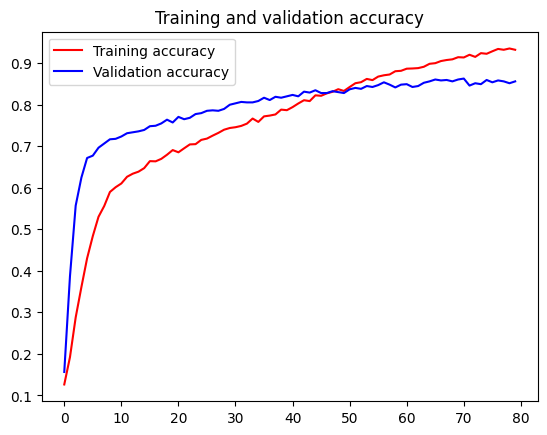

<Figure size 640x480 with 0 Axes>

In [21]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

### Plotting train & validation loss

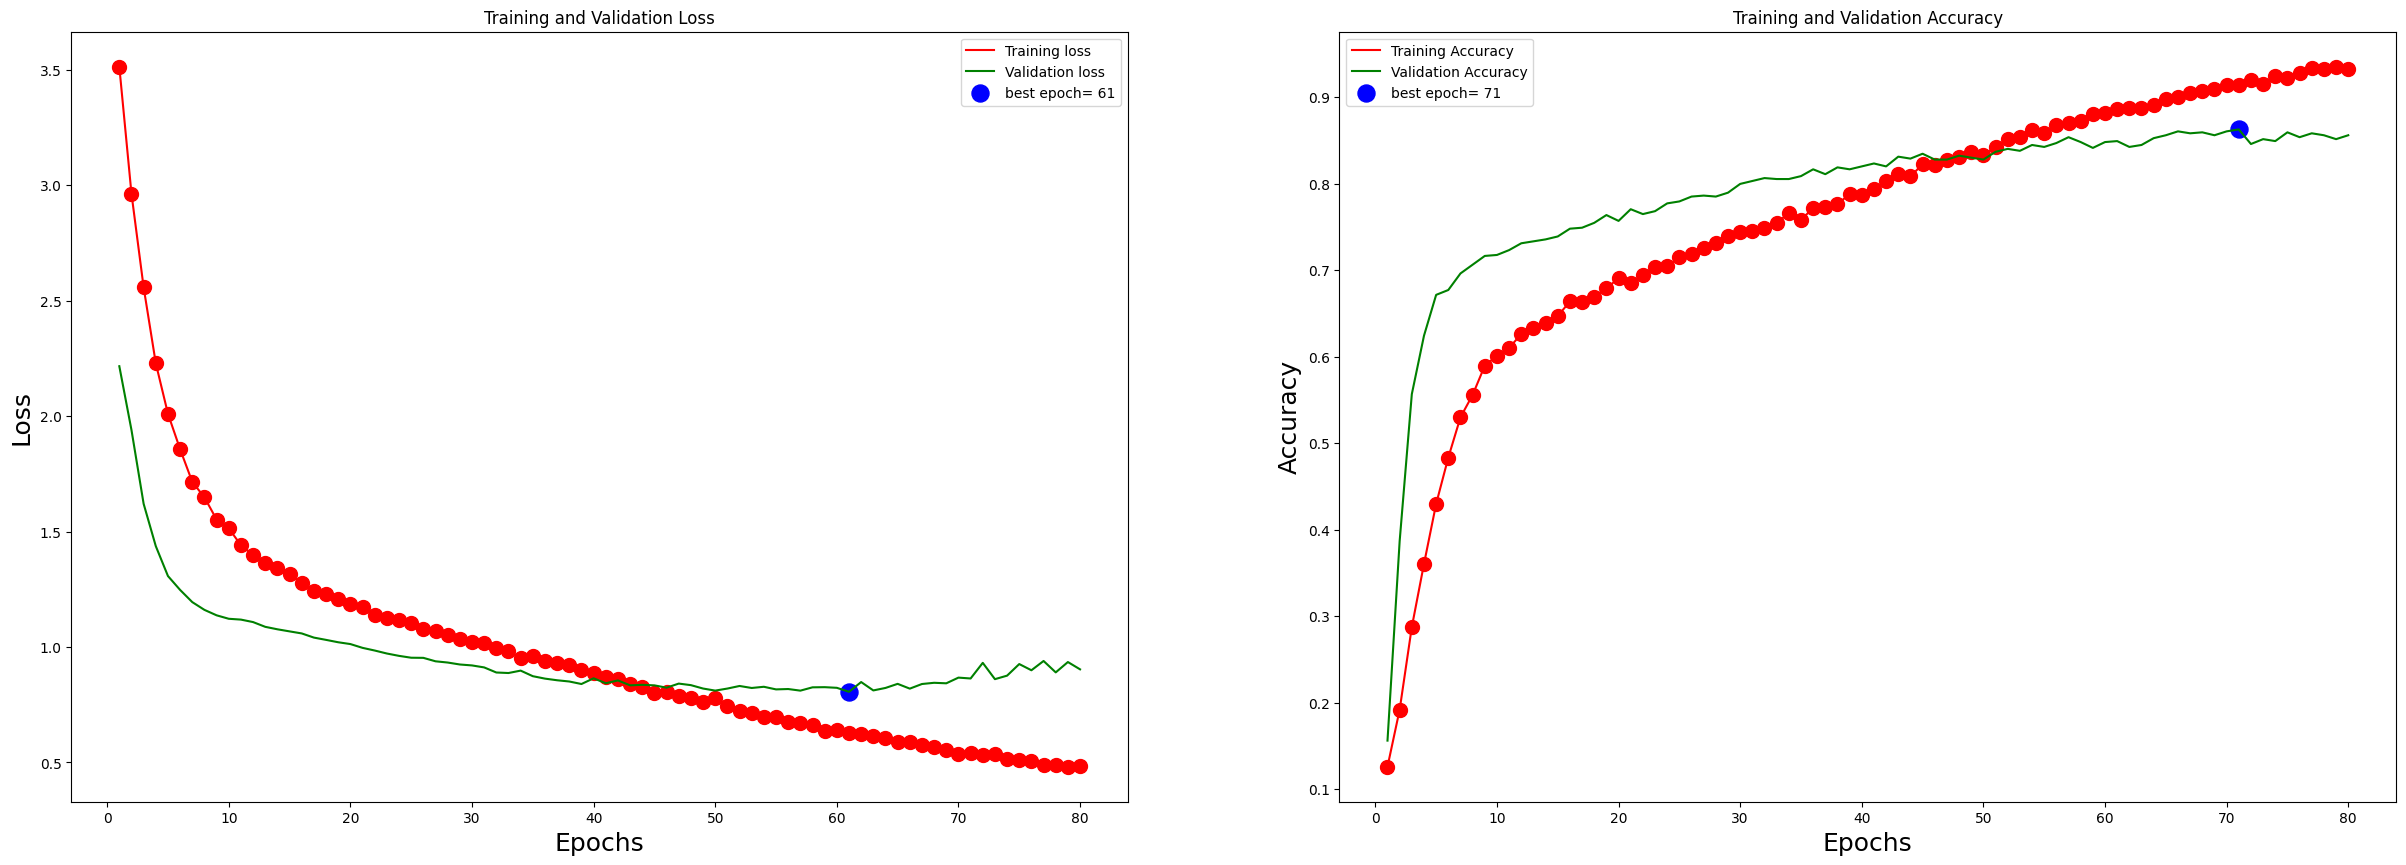

In [22]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(30,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout
    plt.show()
    return index_loss

loss_index=tr_plot(model_history,0)

### Confusion Matrix

In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print(msg)
    
    
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    
    print("\n\nClassification Report:\n----------------------\n", clr)
    return errors, tests


errors, tests=predictor(test_gen, test_steps)

### Accuracy & Loss

In [19]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

print(f"Test Loss: {test_loss * 100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.8614 - loss: 0.7783


W0000 00:00:1715005548.181000      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Accuracy: 86.44%


# GradCAM & GradCAM++

In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
import tensorflow as tf

In [24]:
loaded_model = load_model('/kaggle/working/my_model_v5.h5')

In [ ]:
# loaded_model.summary()

In [37]:
def grad_cam_plus(model, img,
                  layer_name="top_conv", label_name=None,
                  category_id=None):
    """Get a heatmap by Grad-CAM++.

    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.

    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs[0]], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id is None:
                    category_id = np.argmax(predictions[0])
                if label_name is not None:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_cam_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap

In [109]:
def grad_cam(model, img,
             layer_name="top_conv", label_name=None,
             category_id=None):
    """Get a heatmap by Grad-CAM.

    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.

    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs[0]], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id is None:
            category_id = np.argmax(predictions[0])
        if label_name is not None:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return np.squeeze(heatmap)

In [38]:
def show_imgwithheat(img_path, heatmap, alpha=0.8, return_array=False):
    """Show the image with heatmap.

    Args:
        img_path: string.
        heatmap: image array, get it by calling grad_cam().
        alpha: float, transparency of heatmap.
        return_array: bool, return a superimposed image array or not.
    Return:
        None or image array.
    """
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = Image.fromarray(superimposed_img)

    return superimposed_img

1776    Melanoma
Name: cell_type, dtype: object


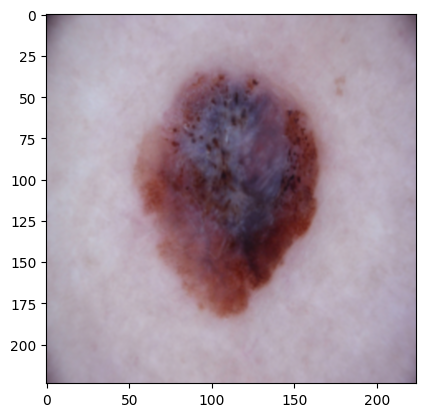

In [204]:
sample = skin_df.sample(n=1)
path = sample.path.iloc[0]
image = np.asarray(Image.open(path))
image = cv2.resize(image, (224,224))

print(sample.cell_type)
plt.imshow(image,interpolation = 'bicubic')

In [205]:
heatmap_plus=grad_cam_plus(model, image, label_name=None, category_id=None)

In [206]:
heatmap=grad_cam(model, image, label_name=None, category_id=None)

In [ ]:
hetmap_plus_output = show_imgwithheat(path, heatmap_plus)
plt.imshow(hetmap_plus_output, interpolation = 'bicubic')

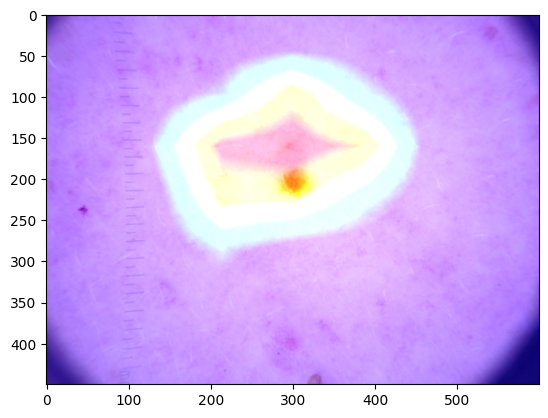

In [194]:
heatmap_output = show_imgwithheat(path, heatmap)
plt.imshow(heatmap_output,interpolation = 'bicubic')